# TMDB 5000 Movies - 502 Final Project - Ethan Katnic

## Dataset Description
I found this dataset on Kaggle.com from the following link as I searched for interesting datasets: https://cosmos11.osdinfra.net/cosmos/User360_Shared/my/PracticeQuery/test1.ss

I found this dataset to be fairly reputable based on the fact that it is curated by both TheMovieDB and Kaggle itself in tandem, as opposed to being generated by just a single individual. It also has over 650,000 views and nearly 100,000 downloads, so it is quite a popular dataset on the Kaggle forum. 

The data in this dataset is pulled from the API of TheMovieDB at https://www.themoviedb.org/. The Python script that was used to query the API can be found here: https://gist.github.com/SohierDane/4a84cb96d220fc4791f52562be37968b. This is a popular and well-documented API that I have personally used before. 

The columns of the data that I used are the following: 

* **budget**     - numeric dollars

* **genres**     - JSON of genres of the film

* **original_language** - Original spoken language of the film

* **popularity** - Relative popularity compared to all other movies

* **production_company** - JSON list of production companies associated with film

* **production_countries** - JSON list of where film was produced

* **release_date**- *year-month-day* of film release date

* **revenue**    - Revenue of film in dollars

* **runtime**    - Runtime in minutes

* **title**      - Title of movie

* **vote_average** - Average rating vote score (1-10)

* **vote_count** - Total number of votes

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import ast

## Read in and clean dataset

### Drop unusable columns

In [2]:
df = pd.read_csv("tmdb_5000_movies.csv")
# Drop unusuable columns
df = df.drop(["homepage","id", "tagline","status", "overview", "spoken_languages", "original_title", "keywords"], axis = 1)

### Column headers

In [3]:
# Column headers do not need reformatting. All in proper column_name form
df.columns

Index(['budget', 'genres', 'original_language', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'title', 'vote_average', 'vote_count'],
      dtype='object')

### Parsing JSON

In [4]:
# Must parse the JSON columns (genres, production companies, production countries,
# to extract primary genre/prod company/country)
primary_genre = []
for movie in df.genres:
    if(len(ast.literal_eval(movie)) > 0):
        primary_genre.append(ast.literal_eval(movie)[0]["name"])
    else:
        primary_genre.append(np.nan)
    
primary_production = []
for movie in df.production_companies:
    if(len(ast.literal_eval(movie)) > 0):
        primary_production.append(ast.literal_eval(movie)[0]["name"])
    else:
        primary_production.append(np.nan)

prod_country_iso = []
for movie in df.production_countries:
    if(len(ast.literal_eval(movie)) > 0):
        prod_country_iso.append(ast.literal_eval(movie)[0]['iso_3166_1'])
    else:
        prod_country_iso.append(np.nan)

In [5]:
# Create primary genre/production/production country columns and drop old JSON
df["primary_genre"] = primary_genre
df["primary_prod"] = primary_production
df["prod_country_iso"] = prod_country_iso
df = df.drop(["genres", "production_companies", "production_countries"], axis = 1)

### Handle nan and missing values

In [98]:
# ISSUE: Budget and revenue are often 0, essentially serving as NA
print("Missing Values: ")
print("Budget:" , df[df.budget==0].budget.count())
print("Revenue:", df[df.revenue==0].revenue.count())
print("Runtime:", df[df.runtime==0].runtime.count())
print("VoteAvg", df[df.vote_average==0].vote_average.count())
print("VoteCount", df[df.vote_count==0].vote_count.count())
print("NAs:")
print(df.isna().sum())

Missing Values: 
Budget: 0
Revenue: 0
Runtime: 0
VoteAvg 24
VoteCount 24
NAs:
budget                776
original_language       0
popularity              0
release_date            0
revenue              1127
runtime                 0
title                   0
vote_average            0
vote_count              0
primary_genre           0
primary_prod            0
prod_country_iso        0
dtype: int64


In [99]:
# Replace the missing values with nan and impute two null runtimes with average runtime
df.loc[df['runtime'] == 0, 'runtime'] = np.nan
df.loc[df['budget'] == 0, 'budget'] = np.nan
df.loc[df['revenue'] == 0, 'revenue'] = np.nan
df.loc[df['vote_average'] == 0, 'vote_average'] = np.nan
df.loc[df['vote_count'] == 0, 'vote_count'] = np.nan
df.runtime = df.runtime.fillna(df.runtime.mean())

In [100]:
# Show NAs and blanks after replacing
print("Missing Values: ")
print("Budget:" , df[df.budget==0].budget.count())
print("Revenue:", df[df.revenue==0].revenue.count())
print("Runtime:", df[df.runtime==0].runtime.count())
print("NAs:")
print(df.isna().sum())

Missing Values: 
Budget: 0
Revenue: 0
Runtime: 0
NAs:
budget                776
original_language       0
popularity              0
release_date            0
revenue              1127
runtime                 0
title                   0
vote_average           24
vote_count             24
primary_genre           0
primary_prod            0
prod_country_iso        0
dtype: int64


In [9]:
print(df.groupby('primary_genre').count().title.sort_values(ascending=False).head(5), "\n")
print(df.groupby('prod_country_iso').count().title.sort_values(ascending=False).head(5),"\n")
print(df.groupby('primary_prod').count().title.sort_values(ascending=False).head(10))

primary_genre
Drama        1207
Comedy       1042
Action        754
Adventure     339
Horror        300
Name: title, dtype: int64 

prod_country_iso
US    3102
GB     374
CA     220
DE     200
FR     174
Name: title, dtype: int64 

primary_prod
Paramount Pictures                        281
Universal Pictures                        260
Columbia Pictures                         200
Twentieth Century Fox Film Corporation    177
New Line Cinema                           157
Walt Disney Pictures                      114
Miramax Films                              87
United Artists                             72
Village Roadshow Pictures                  71
Columbia Pictures Corporation              65
Name: title, dtype: int64


####  Since there are only 27 missing genres, and the vast majority of films are produced in the US,  replace the missing primary genre and missing production countries with the mode of each.

In [10]:
df.primary_genre = df.primary_genre.fillna(df['primary_genre'].mode()[0])
df.prod_country_iso = df.prod_country_iso.fillna(df['prod_country_iso'].mode()[0])

In [101]:
# Drop the single null release date, as this is difficult to impute
df = df[df['release_date'].notnull()]
# Drop the rows with no voting data
df = df[df['vote_average'].notnull()]
df = df[df['vote_count'].notnull()]
# Additionally, drop the ~350 rows with missing primary production companies, as this too is
# difficult to impute with the way that the produciton companies are distributed
df = df[df['primary_prod'].notnull()]

In [125]:
print("Missing Values: ")
print("Budget:" , df[df.budget==0].budget.count())
print("Revenue:", df[df.revenue==0].revenue.count())
print("Runtime:", df[df.runtime==0].runtime.count())
print("NAs:")
print(df.isna().sum())

Missing Values: 
Budget: 0
Revenue: 0
Runtime: 0
NAs:
budget                760
original_language       0
popularity              0
release_date            0
revenue              1105
runtime                 0
title                   0
vote_average            0
vote_count              0
primary_genre           0
primary_prod            0
prod_country_iso        0
dtype: int64


In [103]:
# Finally, since the financial data (budget and revenue) is missing from almost 25% of the rows,
# I chose to drop these rows instead of imputing them, as I felt that using mean of budget and revenue
# would not be an accurate way to fill these values given the variation in both of these fields.
df_imputed = df[df['budget'].notnull()]
df_imputed = df_imputed[df_imputed['revenue'].notnull()]

In [104]:
print("Missing Values: ")
print("Budget:" , df_imputed[df_imputed.budget==0].budget.count())
print("Revenue:", df_imputed[df_imputed.revenue==0].revenue.count())
print("Runtime:", df_imputed[df_imputed.runtime==0].runtime.count())
print("NAs:")
print(df_imputed.isna().sum())

Missing Values: 
Budget: 0
Revenue: 0
Runtime: 0
NAs:
budget               0
original_language    0
popularity           0
release_date         0
revenue              0
runtime              0
title                0
vote_average         0
vote_count           0
primary_genre        0
primary_prod         0
prod_country_iso     0
dtype: int64


### One-hot Encoding

In [105]:
# Upon inspecting production company, there are hundreds and hundreds of companies that have only produced one movie.
# This is problematic, as I do not want a dummy variable for every one of these small production companies.
# As an alternative, I replaced all production companies that have produced fewer than 10 movies with "Small Production Company"
df_imputed['prod_company_movie_count'] = df_imputed.groupby('primary_prod')['title'].transform(len)
df_imputed.loc[df_imputed.prod_company_movie_count < 20, 'primary_prod'] = "Small Production Company"
df_imputed = df_imputed.drop("prod_company_movie_count", axis = 1)

In [106]:
df_imputed.groupby(['primary_prod'])['title'].count().sort_values(ascending=False)

primary_prod
Small Production Company                  1459
Paramount Pictures                         241
Universal Pictures                         228
Columbia Pictures                          166
Twentieth Century Fox Film Corporation     159
New Line Cinema                            135
Walt Disney Pictures                        96
Village Roadshow Pictures                   64
United Artists                              61
Miramax Films                               61
Columbia Pictures Corporation               58
DreamWorks SKG                              54
Warner Bros.                                54
Fox Searchlight Pictures                    46
Summit Entertainment                        40
TriStar Pictures                            36
Metro-Goldwyn-Mayer (MGM)                   33
The Weinstein Company                       27
Lionsgate                                   27
Regency Enterprises                         26
Touchstone Pictures                         25


In [107]:
# Upon inspecting the production country, I saw a similar pattern and decided to implement a similar
# approach to reduce the overwhelming number of dummy columns, grouping countries where fewer than 10
# films have been produced in as "Other Country"
df_imputed['prod_country_count'] = df_imputed.groupby('prod_country_iso')['title'].transform(len)
df_imputed.loc[df_imputed.prod_country_count < 10, 'prod_country_iso'] = "Other Country"
df_imputed = df_imputed.drop("prod_country_count", axis = 1)

In [108]:
df_imputed.groupby(['prod_country_iso'])['title'].count().sort_values(ascending=False)

prod_country_iso
US               2227
GB                253
DE                144
CA                127
FR                107
Other Country      94
AU                 62
JP                 25
CN                 24
IN                 22
ES                 22
IE                 16
IT                 15
NZ                 15
MX                 12
HK                 11
CZ                 10
Name: title, dtype: int64

In [109]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_imputed.select_dtypes(exclude=numerics).drop(["title","release_date"], axis=1).head()

,original_language,primary_genre,primary_prod,prod_country_iso
0,en,Action,Small Production Company,US
1,en,Adventure,Walt Disney Pictures,US
2,en,Action,Columbia Pictures,GB
3,en,Action,Small Production Company,US
4,en,Action,Walt Disney Pictures,US


In [110]:
df_dummies = pd.get_dummies(data=df_imputed, columns=['original_language', 'primary_genre', 'primary_prod', "prod_country_iso"])

In [111]:
print(len(df_imputed.primary_genre.unique()))
print(len(df_imputed.primary_genre.unique()))
print(len(df_imputed.primary_prod.unique()))
print(len(df_imputed.prod_country_iso.unique()))

19
19
25
17


## Exploratory Analysis

### Examining Distribution

In [112]:
df_dummies.select_dtypes(include=numerics).describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,3.186000e+03,3186.000000,3.186000e+03,3186.000000,3186.000000,3186.000000
mean,4.113670e+07,29.390456,1.228003e+08,110.841808,6.317012,990.112680
std,4.449427e+07,36.275843,1.870663e+08,20.985921,0.855900,1419.469905
min,1.000000e+00,0.037073,5.000000e+00,41.000000,2.300000,1.000000
25%,1.100000e+07,10.792509,1.763340e+07,96.000000,5.800000,188.000000
50%,2.600000e+07,20.746523,5.679228e+07,107.000000,6.300000,483.000000
75%,5.500000e+07,37.677495,1.483932e+08,121.000000,6.900000,1156.500000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,8.500000,13752.000000


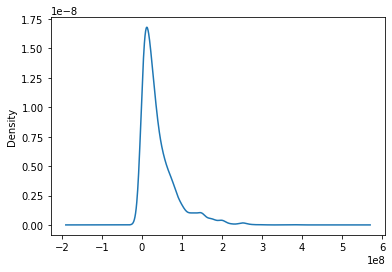

In [113]:
%matplotlib inline
df_dummies.budget.plot(kind='density')

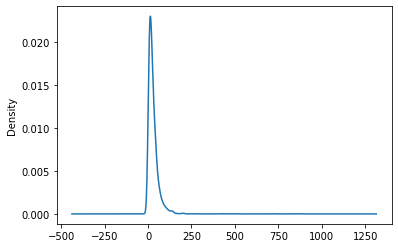

In [114]:
df_dummies.popularity.plot(kind='density')

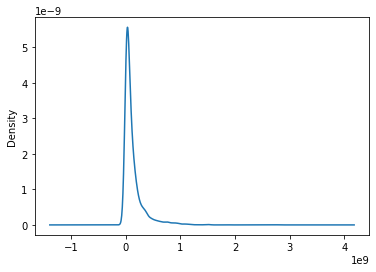

In [115]:
df_dummies.revenue.plot(kind='density')

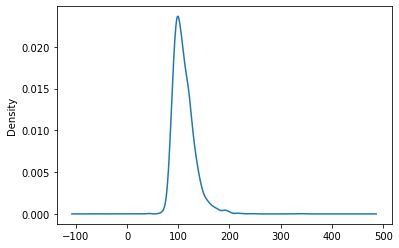

In [116]:
df_dummies.runtime.plot(kind='density')

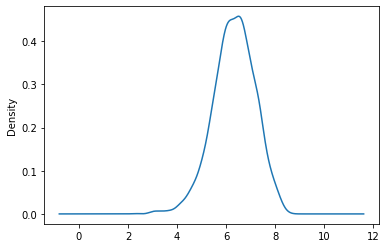

In [117]:
df_dummies.vote_average.plot(kind='density')

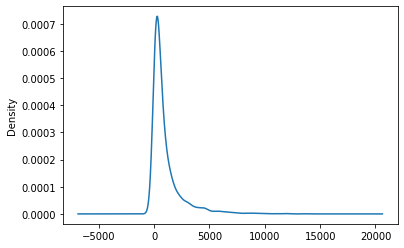

In [118]:
df_dummies.vote_count.plot(kind='density')

### Exploring Correlation Between Independent Variables

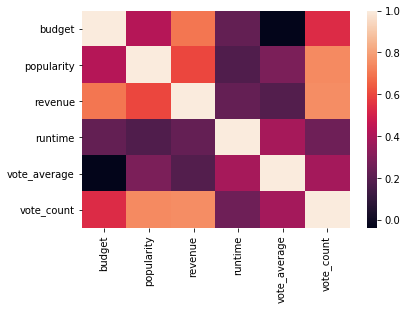

In [119]:
sns.heatmap(df_dummies.select_dtypes(include=numerics).corr())

In [120]:
df_dummies.select_dtypes(include=numerics).corr()

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.427498,0.703627,0.227145,-0.039141,0.536895
popularity,0.427498,1.000000,0.599873,0.179804,0.288807,0.747442
revenue,0.703627,0.599873,1.000000,0.231550,0.188054,0.754856
runtime,0.227145,0.179804,0.231550,1.000000,0.389727,0.256361
vote_average,-0.039141,0.288807,0.188054,0.389727,1.000000,0.383126
vote_count,0.536895,0.747442,0.754856,0.256361,0.383126,1.000000


From the previous heatmap and correlation visuals, we see that `vote_count` is highly correlated with several other independent variables such as `popularity`, `revenue`.

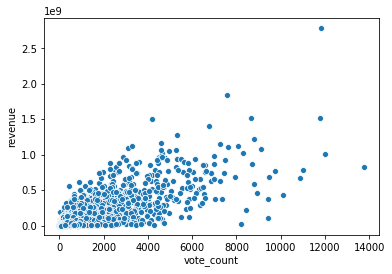

In [121]:
sns.scatterplot(df_dummies.vote_count, df_dummies.revenue)

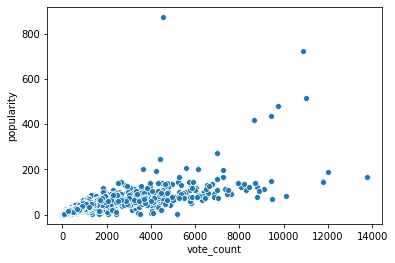

In [122]:
sns.scatterplot(df_dummies.vote_count, df_dummies.popularity)

 For this reason, I felt it best that I drop this column as to avoid issues of collineraity. 

In [123]:
df_dummies = df_dummies.drop("vote_count", axis = 1)
df_dummies.select_dtypes(include=numerics)

,budget,popularity,revenue,runtime,vote_average
0,237000000.0,150.437577,2.787965e+09,162.0,7.2
1,300000000.0,139.082615,9.610000e+08,169.0,6.9
2,245000000.0,107.376788,8.806746e+08,148.0,6.3
3,250000000.0,112.312950,1.084939e+09,165.0,7.6
4,260000000.0,43.926995,2.841391e+08,132.0,6.1
5,258000000.0,115.699814,8.908716e+08,139.0,5.9
6,260000000.0,48.681969,5.917949e+08,100.0,7.4
7,280000000.0,134.279229,1.405404e+09,141.0,7.3
8,250000000.0,98.885637,9.339592e+08,153.0,7.4
9,250000000.0,155.790452,8.732602e+08,151.0,5.7
